In [17]:
##########################################################################

## service Clustring Dataset 2.0 json format							##

##########################################################################
## Format: parameters 		##
## Format: (1) id						exampl: f73b9c6207fd42e3adc4b51a8f8fc5df    ##
## Format: (2) _type					exampl: REST    ##
## Format: (3) source					exampl: https://www.programmableweb.com/api/openstreetmap-rest-api-v06##
## Format: (4) category					exampl: Mapping ##
## Format: (5) url						exampl: http://api.openstreetmap.org/   ##
## Format: (7) description				exampl: OpenStreetMap is the free wiki world map,##
## Format: (8) quality					exampl: null##
##########################################################################


# Service Classification_ Step1: clustering

There is 3 major solutions for ML approaches:

1.	supervised learning

2.	unsupervised learning

3.	hybrid model by combining unsupervised and supervised learning


Most of the web service repositories have a category field to identify their service functionality. therefore, we used the category field as our dataset label. But the main problem is those categories have too much variety. For example, for 6535 services we had 503 categories. 
To solve this problem, we can use a hybrid model by combining unsupervised and supervised learning. Therefore, before service classification, we used cluster services to reduce categories(sections)



## Clustering

The objective of this section is to explore the data and to select a proper clustering algorithm. In our implementation, we used some popular clustering algorithms:

 * K-Means Clustering

 * Agglomerative Hierarchical Clustering


We have tried K-Means algorithm and hierarchical agglomerative clustering. SO, regarding following reason we select hierarchical agglomerative clustering method:

* We will use this clustering method to cluster our dataset, therefore it will happen one time so we don’t care about time complexity of O(n³), Also our dataset is not huge.

* Hierarchical clustering does not require us to specify the number of clusters.

* The tree diagram plot (dendrogram)of Hierarchical clustering makes more sense to understand categories that are close together.


In [18]:
# !pip install -r requirements.txt
# !conda install -c conda-forge wordcloud=1.6.0 -y
# !pip install folium
# !pip install pandas
# !pip install requests 
# !pip install  nltk
# !pip install requests 
# !pip install  unidecode
# !pip install matplotlib
# !pip install matplotlib
# !pip install seaborn

In [19]:
# Data Structures
import numpy  as np
import pandas as pd
import json
import os
import csv

# Corpus Processing
import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

import nltk
nltk.download('stopwords')
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings

# K-Means
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics  import silhouette_samples, silhouette_score
from wordcloud                        import WordCloud


#import branca.colormap as cm
from branca.element import Figure

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bisite/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
df=pd.read_json (r'secound_service_2.json',lines=True)
print ('Number of data points : ', df.shape[0], \
       '\n Number of features/variables:', df.shape[1])


print(df.category.nunique())
df.head(3)

Number of data points :  6535 
 Number of features/variables: 9
363


,_id,source,_type,name,url,category,description,methods,docs
0,0016fe9d99b1408d83a9e304d8d83fc2,https://www.programmableweb.com/api/paysbuy-rp...,RPC,Paysbuy API,https://www.paysbuy.com/developers.aspx?l=e,Payments,The service headquartered in Thailand provides...,[],https://www.paysbuy.com/developers.aspx?l=e
1,00222ddc19354471a1bf2ac186db92a0,https://www.programmableweb.com/api/clickmeter...,REST v2.0,Clickmeter API,https://apiv2.clickmeter.com,Email,The service monitors responses by recipients o...,[],https://apiv2.clickmeter.com
2,002860aed28445588aeaf4f116f1b2cd,https://www.programmableweb.com/api/merriam-we...,REST v3.0,Merriam-Webster Dictionary API,http://www.dictionaryapi.com/api/,Dictionary,The Merriam-Webster Dictionary API gives devel...,[],http://www.dictionaryapi.com/api/


363


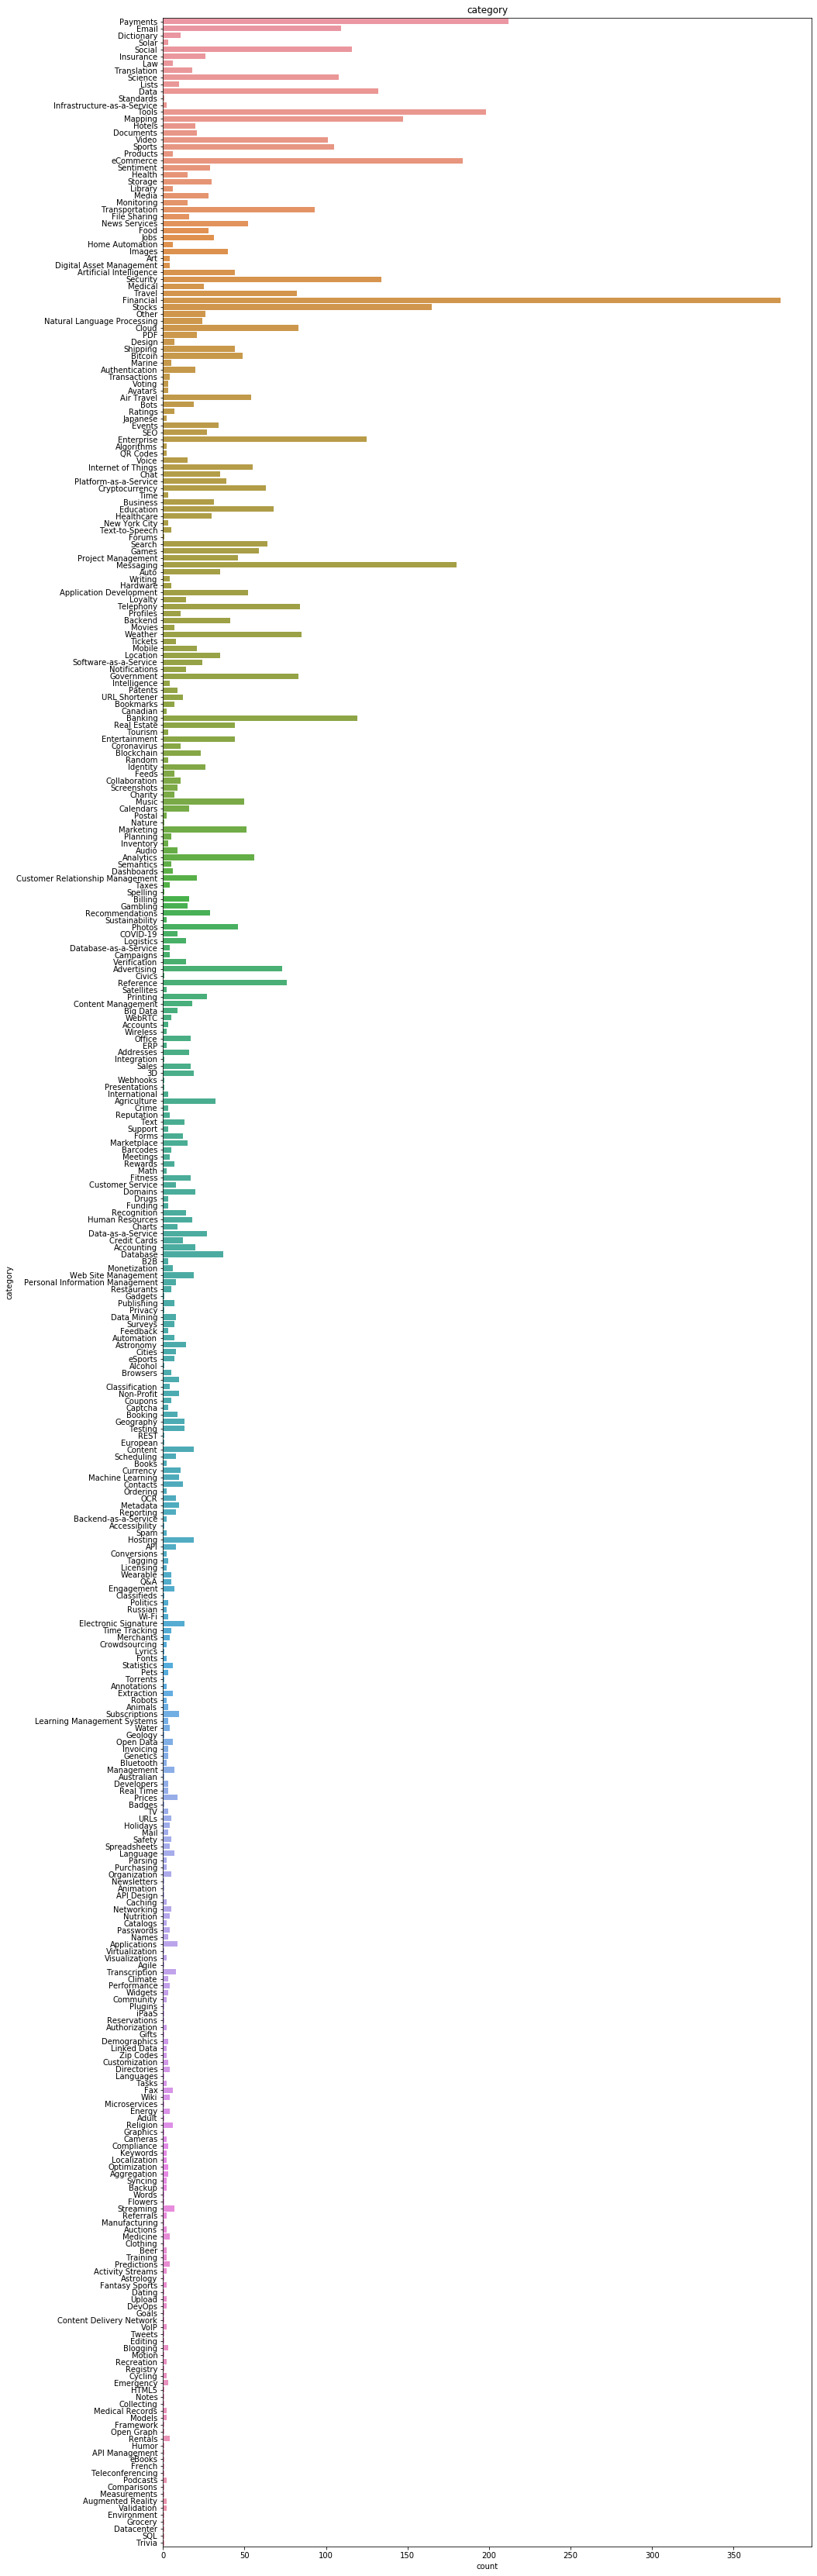

In [21]:

fg, axs = plt.subplots(1, 1, figsize=(15,60))

ax = sns.countplot(y="category", data=df)
plt.title('category')
print(df.category.nunique())

## Pre Processing

1- convert universal type for services for example REST V2 and REST V1 will RESt. In current approches we ignore service resrt versioning and focus on service description.

In [22]:
#preprocessing
df2=df
df2.loc[df['_type'].str.contains('REST', regex=True)==True, "_type"] = "REST"
df2.loc[df['_type'].str.contains('RPC', regex=True)==True, "_type"] = "RPC"
df2.loc[df['_type'].str.contains('FEED', regex=True)==True, "_type"] = "FEED"
df2.loc[df['_type'].str.contains('Indirect', regex=True)==True, "_type"] = "Indirect"
df2.loc[df['_type'].str.contains('Streaming', regex=True)==True, "_type"] = "Streaming"
df2.loc[df['_type'].str.contains('Unspecified', regex=True)==True, "_type"] = "Unspecified"
df2.loc[df['_type'].str.contains('Native/Browser', regex=True)==True, "_type"] = "Native/Browser"


List_Of_Categories_In_Column=list(df2['_type'].value_counts().index)
List_Of_Categories_In_Column

['REST',
 'RPC',
 'Streaming',
 'Unspecified',
 'Indirect',
 'Native/Browser',
 'FEED',
 'EMAIL/MESSAGING/FTP',
 '']

## Remove useless coulmns

In [23]:
df3=df2.drop(['_id'],errors='ignore', axis=1)
df3=df3.drop(['_type'], errors='ignore', axis=1)
df3=df3.drop(['source'] ,errors='ignore', axis=1)
df3=df3.drop(['methods'], errors='ignore', axis=1)
df3=df3.drop(['url'], errors='ignore', axis=1)
df3=df3.drop(['docs'], errors='ignore', axis=1)

df3

,name,category,description
0,Paysbuy API,Payments,The service headquartered in Thailand provides...
1,Clickmeter API,Email,The service monitors responses by recipients o...
2,Merriam-Webster Dictionary API,Dictionary,The Merriam-Webster Dictionary API gives devel...
3,Clean Power Research Solar Simulations API,Solar,Clean Power Research builds services for energ...
4,Shoudio API,Social,Shoudio is a location based audio platform tha...
...,...,...,...
6530,Sift Score API,Security,Sift Score API is a REST API that provides a r...
6531,MessageBird Personal Data API,Messaging,The MessageBird Personal Data API is currently...
6532,Direct Mail API,Email,Direct Mail is a Mac OS X app for designing em...
6533,AddTransit API,Transportation,The AddTransit API enables easy integration be...


## Description to lowercase

In [24]:
df4=df3
df4['description']=df4['description'].str.lower()

## Remove None / Null value from description¶


In [25]:
df4 = df4[pd.notnull(df4['description'])]
df4
print(df4.category.nunique())

363


## Remove category with low frequency


In [26]:
counts_category = df4.groupby("category")["category"].transform(len)

mask_will_remove = (counts_category < 30)
df_will_remove=df4
df_will_remove=df4[mask_will_remove]
# df_will_remove



## Display Removed categories

309


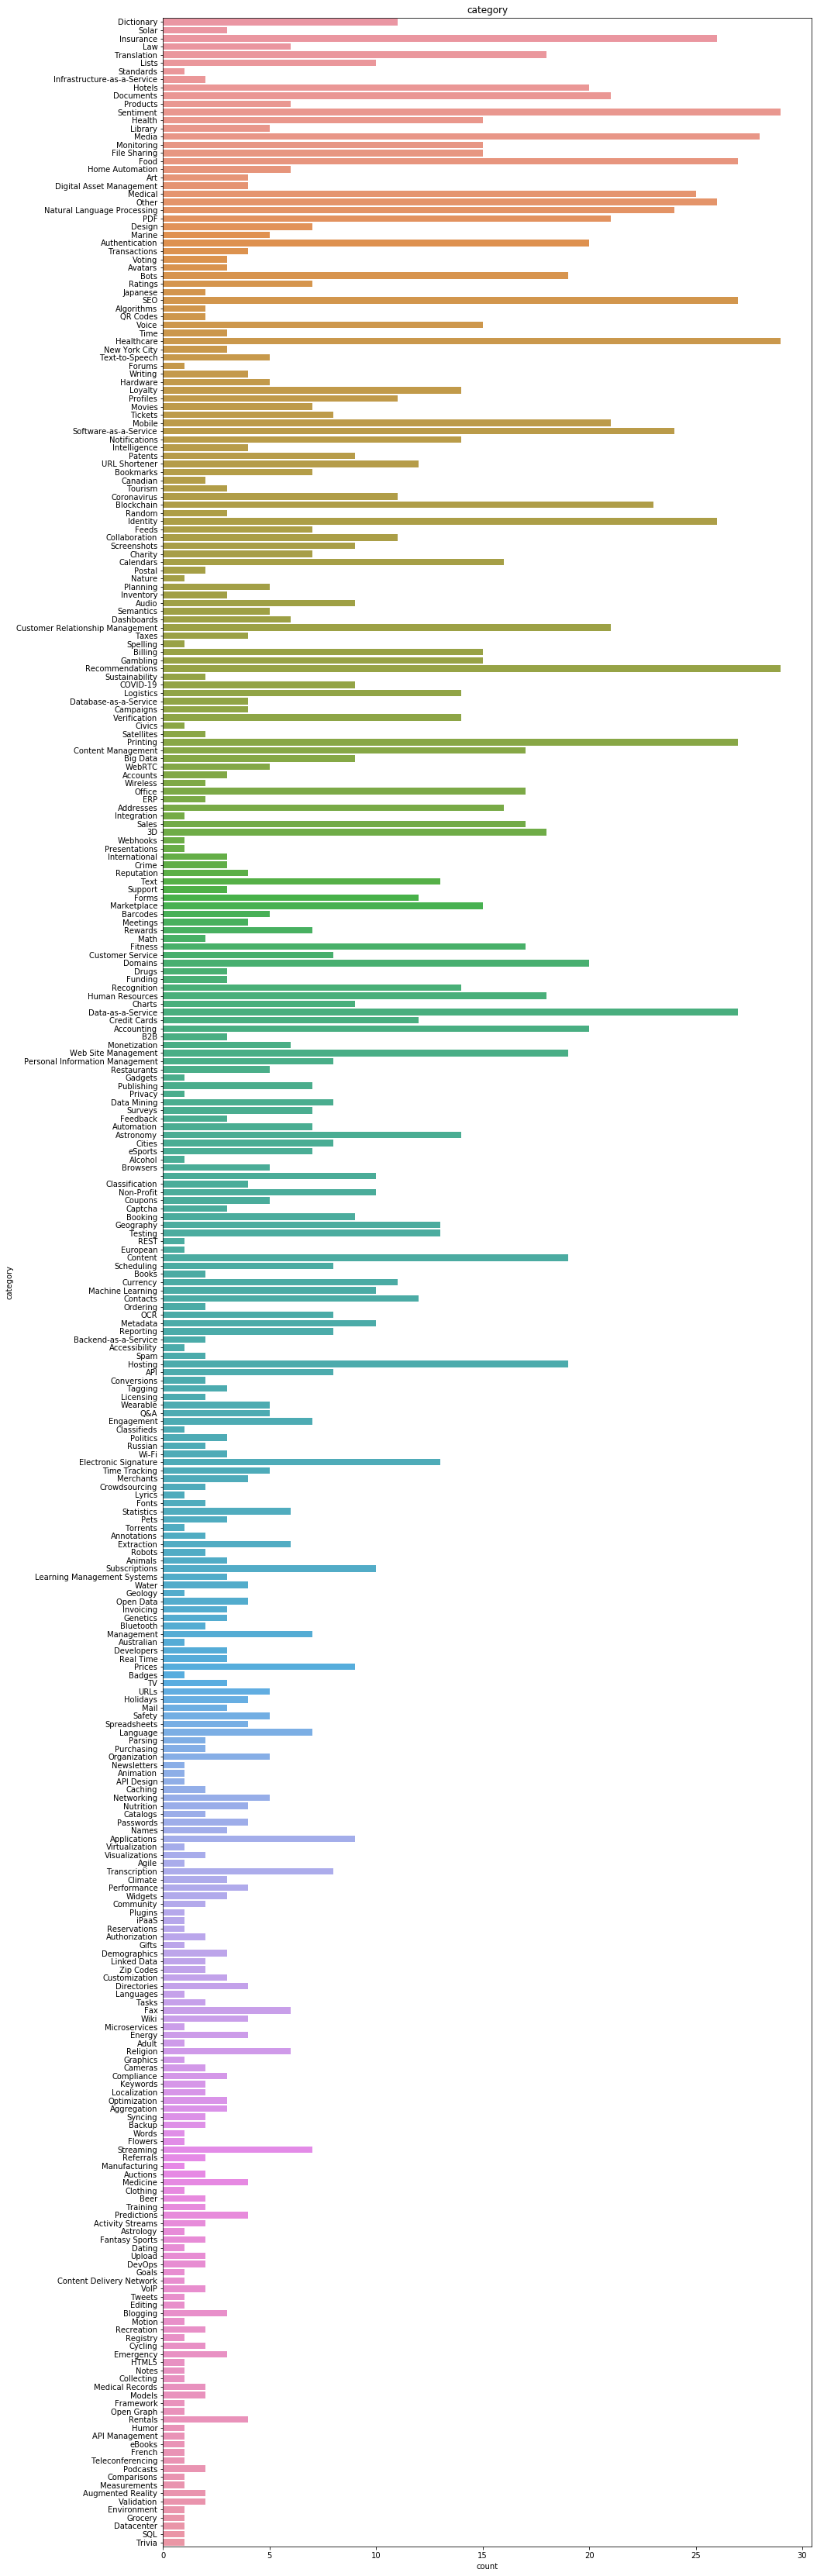

In [27]:

fg, axs = plt.subplots(1, 1, figsize=(15,60))

ax = sns.countplot(y="category", data=df_will_remove)
plt.title('category')
print(df_will_remove.category.nunique())

In [28]:
counts_category = df4.groupby("category")["category"].transform(len)

mask = (counts_category > 30 )

df4=df4[mask]
# df4


## Display selected categories

53


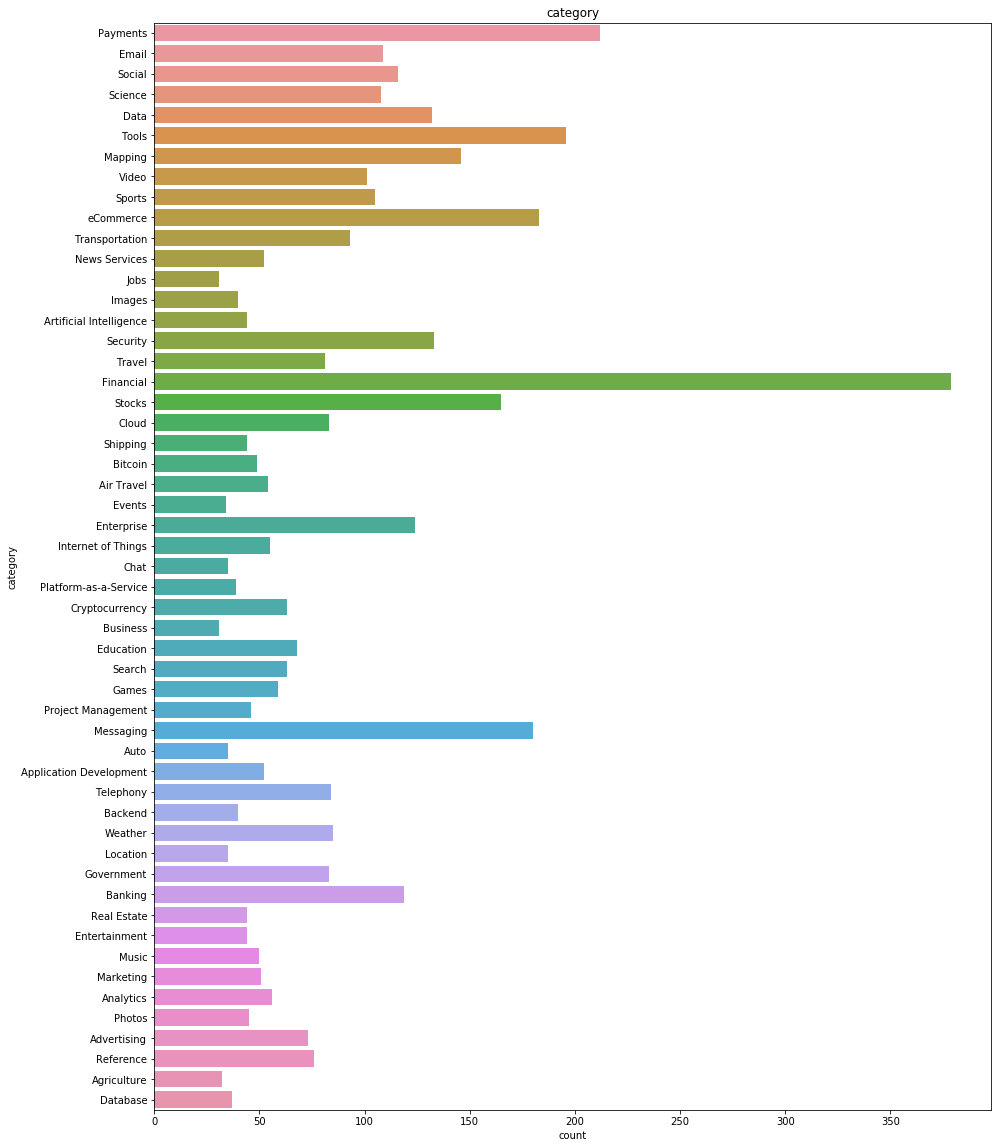

In [29]:
fg, axs = plt.subplots(1, 1, figsize=(15,20))

ax = sns.countplot(y="category", data=df4)
plt.title('category')
df4.category.value_counts()
# to see how many unique value is in column
print(df4.category.nunique())

## Remove Stopwordsand + Punctuation or special characters

In [30]:
import nltk
nltk.download('stopwords')

#function to clean the word of any punctuation or special characters
def cleanPunc(sentence): 
    cleaned = re.sub(r'[?|!|\[|\]|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|)|(|\|/]',r' ',cleaned)
    cleaned = re.sub(r'[\d]',r' ',cleaned)#remove digite
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n","")
    return cleaned

df4['description'] = df3['description'].astype(str).apply(cleanPunc)
df4['description']

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bisite/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0       the service headquartered in thailand provides...
1       the service monitors responses by recipients o...
4       shoudio is a location based audio platform tha...
8       this api allows you to collect image data gath...
10      the microbilt ssn validation api is a web serv...
                              ...                        
6530    sift score api is a rest api that provides a r...
6531    the messagebird personal data api is currently...
6532    direct mail is a mac os x app for designing em...
6533    the addtransit api enables easy integration be...
6534    a safe place to store, organize and share your...
Name: description, Length: 4494, dtype: object

In [32]:
#function for remove stop words, for example google should remove?
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten',
                   '1','2','3','4','5','6','7','8','9','10',
                   'may','also','across','among','beside','however','yet','within','many',
                   'first','second','third','fifth','this','the','monthly',"google","yahoo","Google","Yahoo","api"])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

df5 = df4
df5['description'] = df5['description'].apply(removeStopWords)
df5['description']


0        service headquartered  thailand provides  onl...
1        service monitors responses  recipients  marke...
4       shoudio   location based audio platform  lets ...
8         allows   collect image data gathered  nasas ...
10       microbilt ssn validation    web service  conf...
                              ...                        
6530    sift score    rest   provides  risk score  use...
6531     messagebird personal data   currently  beta  ...
6532    direct mail   mac os x app  designing email ne...
6533     addtransit  enables easy integration   addtra...
6534     safe place  store, organize  share  photos   ...
Name: description, Length: 4494, dtype: object

### Tokenize

In [33]:
nltk.download('punkt')
nltk.download('wordnet')

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.tokenize import WhitespaceTokenizer
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer


df6 = df5
from nltk.tokenize import RegexpTokenizer
tokenizer=RegexpTokenizer(r'\w+')

df6['description'] = df5['description'].apply(lambda x:tokenizer.tokenize(x.lower()))
df6['description']



[nltk_data] Downloading package punkt to /Users/bisite/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/bisite/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0       [service, headquartered, thailand, provides, o...
1       [service, monitors, responses, recipients, mar...
4       [shoudio, location, based, audio, platform, le...
8       [allows, collect, image, data, gathered, nasas...
10      [microbilt, ssn, validation, web, service, con...
                              ...                        
6530    [sift, score, rest, provides, risk, score, use...
6531    [messagebird, personal, data, currently, beta,...
6532    [direct, mail, mac, os, x, app, designing, ema...
6533    [addtransit, enables, easy, integration, addtr...
6534    [safe, place, store, organize, share, photos, ...
Name: description, Length: 4494, dtype: object

## Lemmatizer

In [34]:
#steming is more brutall for example it removes "e" from words for example change --->chang
#So we select Lemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()

def word_lemmatizer(text):
    lem_text=" ".join([lemmatizer.lemmatize(i) for i in text])
    return lem_text

df7=df6
df7['description']=df6['description'].apply(lambda x:word_lemmatizer(x))
df7['description']

0       service headquartered thailand provides online...
1       service monitor response recipient marketing c...
4       shoudio location based audio platform let user...
8       allows collect image data gathered nasa curios...
10      microbilt ssn validation web service confirms ...
                              ...                        
6530    sift score rest provides risk score user e com...
6531    messagebird personal data currently beta allow...
6532    direct mail mac o x app designing email newsle...
6533    addtransit enables easy integration addtransit...
6534    safe place store organize share photo feature ...
Name: description, Length: 4494, dtype: object

## Remove High Ferequency words

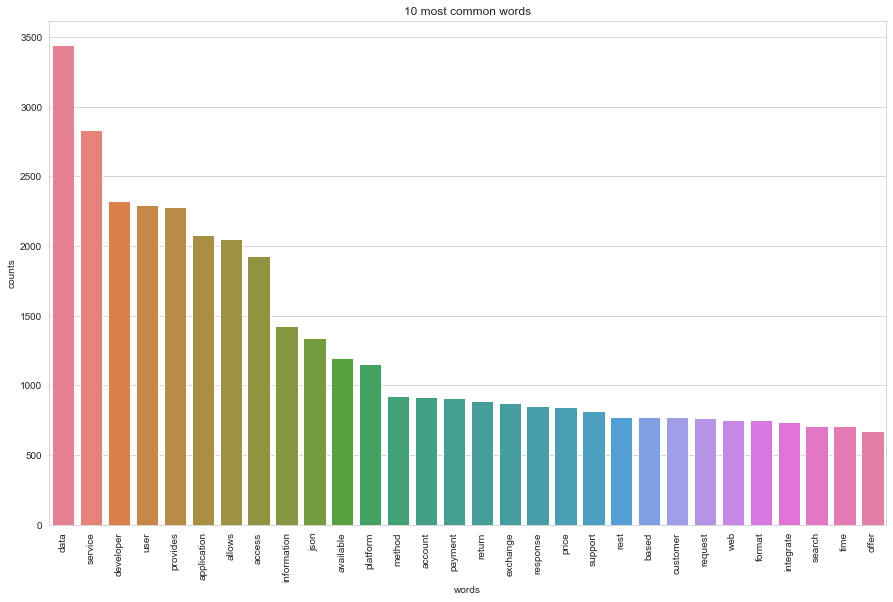

In [35]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as npimport
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

df10=df7

def find_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:30]

    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    return words


def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:30]

    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()# Initialise the count vectorizer with the English stop words
    return words
count_vectorizer = CountVectorizer(stop_words='english')# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df10['description'])# Visualise the 10 most common words
words=plot_10_most_common_words(count_data, count_vectorizer)



In [36]:
# To_remove_lst=words
# df10['description'] = df10['description'].str.replace('|'.join(To_remove_lst), '')
# df10['description']

In [37]:
# count_vectorizer = CountVectorizer(stop_words='english')# Fit and transform the processed titles
# count_data = count_vectorizer.fit_transform(df10['description'])# Visualise the 10 most common words
# words=find_10_most_common_words(count_data, count_vectorizer)

## Remove founded rfrequensed word as stop word
 after several trype found following words and remove as stop words

In [38]:
stop_words = set(stopwords.words('english'))
stop_words.update(['code',
                   'number', 'get', 'us', 'featuer','help', 'online', 'site', 'include', 'open', 'enables', 'real', 'http',
                   "including", "featuers",
                   'application', 'responses', 'stock', 'format', 'offers', 'retrieve', 'calls', 'requests',
                   'functionality', 'key', 'includes', 'customers', 'features', 'location', 'content',
                   'financi', 'management', 'mobile', 'text', 'com', 'base', 'tools', 'public'  'way', 'software',
                   'send', 'company', 'request', 'products', 'specific'   'ful', 'sites', 'day', 'intrinio',
                   'list', 'trading', 'manage', 'authentication', 'customer', 'solutions',
                   'support', 'xml', 'new', 'end', 'make', 'tool', 'supports', 'formatted', 'specific',
                   'provider', 'address', 'public', 'app', 'product', 'global', 'close', 'interface',
                   'managing', 'feed', 'free',
                   'integration', 'retrieving', 'designed', 'provided', 'service', 'format',
                   'analytics', 'results', 'add', 'status', 'historical', 'details', 'apps', 'account', 'data',
                   'provide' , 'service', 'developer', 'user', 'provides', 'system', 'search', 'ful', 'apis', 
                   'al', 'ing', 'es', 'ed', 'use', 'create', 'using', 'used', 'cloud','function', 'let', 'build'
                   'data', 'service', 'developer', 'user', 'provides', 'allows', 'application',
                   'access', 'information', 'json', 'available', 'platform', 'payment',
                   'method','account','exchange', 'price', 'return', 'support','response', 'customer', 'request',  'based',
                   'format', 'integrate', 'rest', 'web','time', 'offer', 'use', 'website', 'back', 'name', 'type', 
                   'example', 'high', 'via ', 'update', 'call', 'restful', 'feature', 'business',  'solution', 'email', 'file'
                   ])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)


def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)


df10['description'] = df10['description'].apply(removeStopWords)
df10['description']


0        headquartered thailand    credit card familia...
1        monitor  recipient marketing communication al...
4       shoudio   audio    record share geo tagged aud...
8        collect image  gathered nasa curiosity opport...
10      microbilt ssn validation   confirms whether su...
                              ...                        
6530    sift score   risk score  e commerce  sift scor...
6531    messagebird personal  currently beta      mult...
6532    direct mail mac  x  designing  newsletter well...
6533    addtransit  easy  addtransit gtfs gtfs realtim...
6534    safe place store organize share photo  rich so...
Name: description, Length: 4494, dtype: object

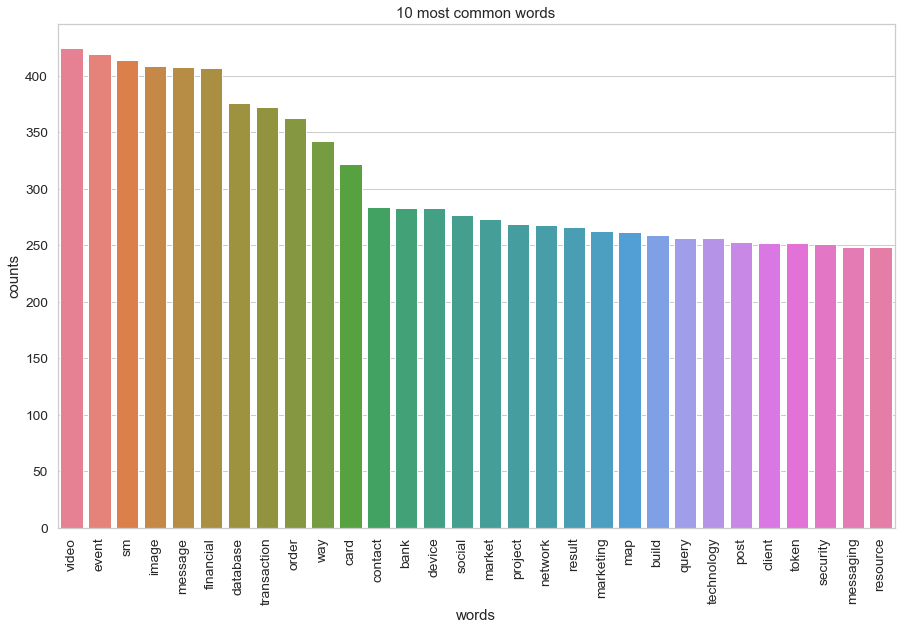

In [39]:
count_vectorizer2 = CountVectorizer(stop_words='english')# Fit and transform the processed titles
count_data2 = count_vectorizer2.fit_transform(df10['description'])# Visualise the 10 most common words
words2=plot_10_most_common_words(count_data2, count_vectorizer2)

# Clustering

Now we are going to clustered dataset using hierarchical clustering. 

## Group By all category
we need to group by all category to just cluster categories

In [40]:
df_groupedby=df10.groupby('category').agg({'name':'sum', 'description':'first','category':'first'})
# df_groupedby.to_csv('groped_by_category_filterd.csv', index = False, header=True)
df10=df_groupedby


## Convert to list all desc

In [41]:
corpus = df10['description'].tolist()
corpus[18][0:447]

'cyfe  dashboard    monitor analyze different   place cyfe push      cyfe  main  pushing   dashboard  channel'

In [42]:
corpus[18][0:460]
corpus

['faxem direct marketing    australia fax  sm marketing  reach client faxem    faxem  stream party  automate task directly perform operation  delete    rpc     secure port required service',
 'usda agriculture resource  survey arm      display analyze  view  agricultural   authenticate   r run sample    graphql format',
 'iag british airway destination     airport city served british airway   shared  parameter required    need register sign mashery id british airway   international airline group iag combine leading airline ireland spain uk enhance presence aviation market',
 'incites  document level metric   research   current research   cris   performance metric paper credited institution clarivate   leader providing trusted insight  accelerate pace innovation',
 'everbase graphql  mutable query common  set utility    associated ip  currency language markdown conversion everbase   plan community  everbase   focus  logic providing faster querying faster development',
 'valossa powered 

# NLP Strategy 
IN NLP There are two technique:

     1-bags of words (our current approach)
     2-Word Embedding

IN Word Embedding , number of dimension is fixed no matter how large the corpus is. (good for in-balanced data) Comparing to bags of words that number of dimension will be increased when unique word increase.

regardingour datasetis medium now we use bag of words

## Bag of word Sterategy (BOW)

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer



vectorizer = TfidfVectorizer(stop_words='english',  max_df=0.7)
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())
# (tf_idf * tf_idf.T).A #similarities matrix of sentences

### Statistical Weighting of Words

Now we will apply the [TF-IDF]function, short for term frequency inverse document frequency, which is a numerical statistic that's intended to reflect how important a word is to a document in a corpus by giving each word in a document a score that ranges from 0 to 1.

In [44]:
vectorizer = TfidfVectorizer(stop_words='english',  max_df=0.7)
vectorizer = vectorizer.fit_transform(corpus)
vectors=vectorizer.toarray()

vectors

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Hierarchical cluster

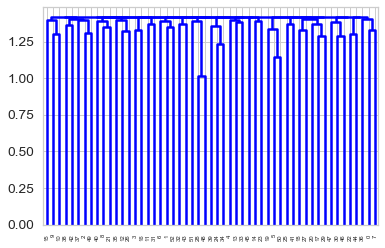

In [45]:
# Agglomerative Clustering
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hac
tree = hac.linkage(vectors, method="complete",metric="euclidean")
plt.clf()
hac.dendrogram(tree)
plt.show() 

In [46]:
from scipy.cluster.hierarchy import fcluster
clustering = fcluster(tree,20,'maxclust')
print(clustering)

[20  8  3  6 12 15  8 20  4  1  1  7  5 12 13  1  6 17 17 15 17  4 19 13
 11 16  5 17 10 17 18  7  9 12 11  5 20  3  2 11  4 16  2  9 19 14 18 18
 10  3 15 10  8]


In [47]:
labels =clustering
df10['cluster_'] = labels
df10[['cluster_','category']]

,cluster_,category
category,,
Advertising,20,Advertising
Agriculture,8,Agriculture
Air Travel,3,Air Travel
Analytics,6,Analytics
Application Development,12,Application Development
Artificial Intelligence,15,Artificial Intelligence
Auto,8,Auto
Backend,20,Backend
Banking,4,Banking


In [48]:
df_groupedby2=df10.groupby(['cluster_'], as_index=False)\
.agg({ 'category':lambda x: ','.join(x)})
df17=df_groupedby2
pd.set_option('display.max_colwidth', -1)
df17[['cluster_','category']].tail(50)

,cluster_,category
0,1,"Bitcoin,Business,Database"
1,2,"Reference,Shipping"
2,3,"Air Travel,Real Estate,Travel"
3,4,"Banking,Financial,Search"
4,5,"Cloud,Jobs,Platform-as-a-Service"
5,6,"Analytics,Education"
6,7,"Chat,Music"
7,8,"Agriculture,Auto,eCommerce"
8,9,"News Services,Social"
9,10,"Mapping,Transportation,Weather"


## Provide clustered Dataset: 

merge origin database Labels based on clustering Result


27
24


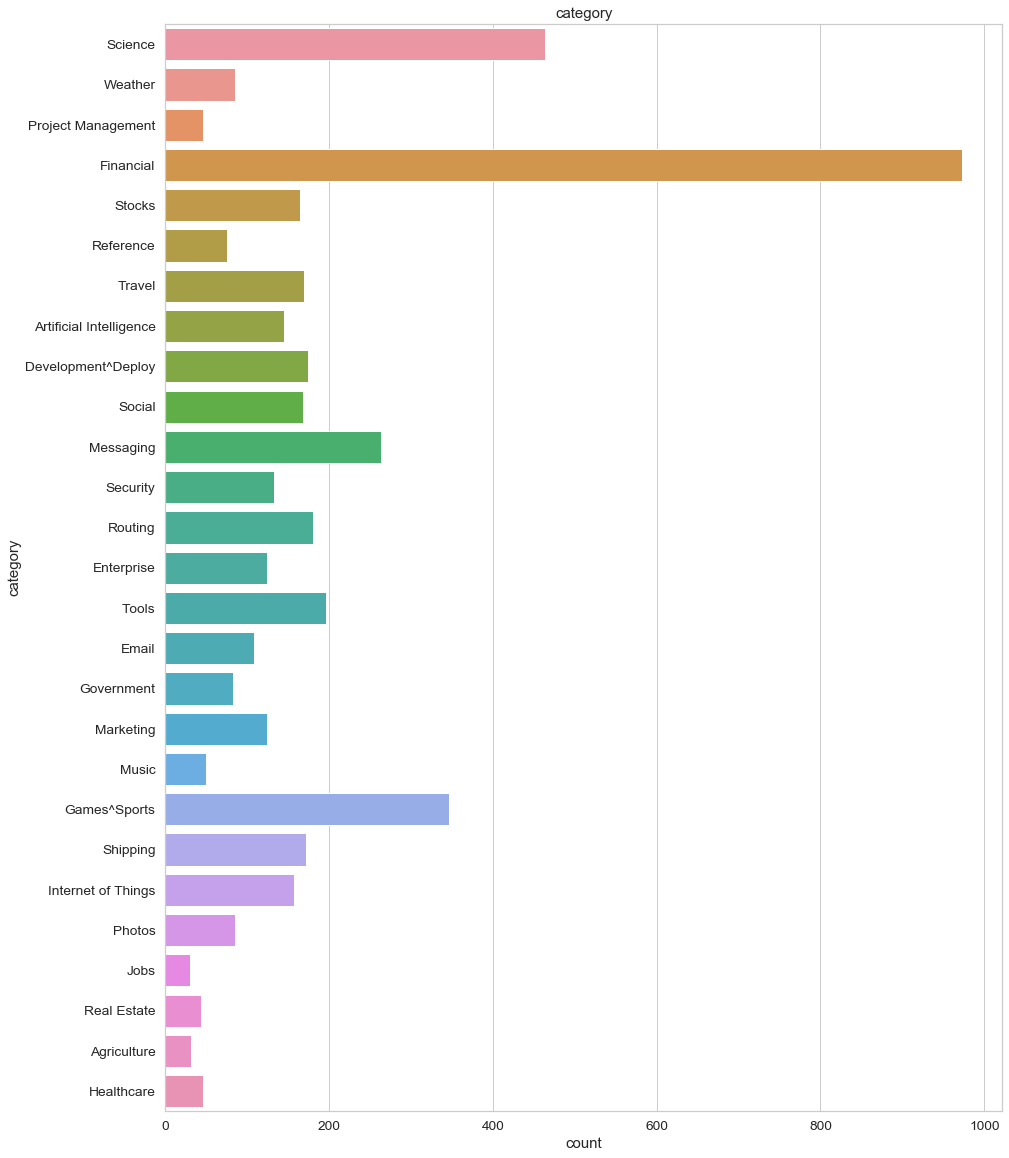

In [49]:
df=pd.read_json (r'secound_service_2.json',lines=True)

### Remove None / Null value from description
df2_=df
df2_ = df2_[pd.notnull(df['description'])]

##thereare some usefull but small groups that we need keep them in our dataset before remove low frequency categories
df_small_usefull_cat = df2_[ 
                            (df2_['category'] == 'Fitness')
                           | (df2_['category'] == 'Healthcare')
#                            | (df2_['category'] == '3D')
                           | (df2_['category'] == 'Sports')
                           | (df2_['category'] == 'Natural Language processing')
                               

                           ]



### Remove categorieswith low frequency
counts_category = df2_.groupby("category")["category"].transform(len)

mask = (counts_category > 30)

df3_=df2_[mask]

# Stack the DataFrames on top of each other
df3_ = pd.concat([df3_, df_small_usefull_cat], axis=0)
df3_ = df3_.sample(frac=1).reset_index(drop=True)

df3_

#mergecategory labels

fg, axs = plt.subplots(1, 1, figsize=(15,20))
# df3_.loc[df3_['category'].astype(str).str.contains('Monitoring|Software-as-a-Service|Tools|Application Development', regex=True)==True, "category"] = "Software-as-a-Service"

df3_.loc[df3_['category'].astype(str).str.contains('Fitness|Healthcare', regex=True)==True, "category"] = "Healthcare"

df3_.loc[df3_['category'].astype(str).str.contains('Data|Search|Analytics|Education|Science', regex=True)==True, "category"] = "Science"

df3_.loc[df3_['category'].astype(str).str.contains('Location|Mapping', regex=True)==True, "category"] = "Routing"
df3_.loc[df3_['category'].astype(str).str.contains('Chat|Shipping|Transportation', regex=True)==True, "category"] = "Shipping"
# df3_.loc[df3_['category'].astype(str).str.contains('Data|Search', regex=True)==True, "category"] = "Data"
# df3_.loc[df3_['category'].astype(str).str.contains('Cloud|Location', regex=True)==True, "category"] = "Cloud"
# df3_.loc[df3_['category'].astype(str).str.contains('Bitcoin|Business', regex=True)==True, "category"] = "Business"
df3_.loc[df3_['category'].astype(str).str.contains('Games|Sports|Entertainment|Events', regex=True)==True, "category"] = "Games^Sports"

# df3_.loc[df3_['category'].astype(str).str.contains('Payments|eCommerce', regex=True)==True, "category"] = "eCommerce"
df3_.loc[df3_['category'].astype(str).str.contains('Natural Language processing|Artificial Intelligence|Video', regex=True)==True, "category"] = "Artificial Intelligence"
# df3_.loc[df3_['category'].astype(str).str.contains('Analytics|Education', regex=True)==True, "category"] = "Education"
df3_.loc[df3_['category'].astype(str).str.contains('Messaging|Telephony', regex=True)==True, "category"] = "Messaging"
df3_.loc[df3_['category'].astype(str).str.contains('Bitcoin|Business|Banking|Financial|Payments|eCommerce', regex=True)==True, "category"] = "Financial"

df3_.loc[df3_['category'].astype(str).str.contains('Application Development|Cloud|Backend', regex=True)==True, "category"] = "Development^Deploy"
df3_.loc[df3_['category'].astype(str).str.contains('News Services|Social', regex=True)==True, "category"] = "Social"

df3_.loc[df3_['category'].astype(str).str.contains('Images|Photos', regex=True)==True, "category"] = "Photos"
df3_.loc[df3_['category'].astype(str).str.contains('Air Travel|Travel|Auto', regex=True)==True, "category"] = "Travel"
df3_.loc[df3_['category'].astype(str).str.contains('Platform-as-a-Service|Blockchain|Cryptocurrency|Internet of Things', regex=True)==True, "category"] = "Internet of Things"
df3_.loc[df3_['category'].astype(str).str.contains('Advertising|Marketing', regex=True)==True, "category"] = "Marketing"


ax = sns.countplot(y="category", data=df3_)
plt.title('category')
print(df3_.category.nunique())
# df3_

#remove some classes
indexNames =df3_[ 
    (df3_['category'] == 'Tools')
#   | (df3_['category'] == 'Software-as-a-Service')
#   | (df3_['category'] == 'Platform-as-a-Service')
    | (df3_['category'] == 'Reference')
#   | (df3_['category'] == 'Project Management')
    | (df3_['category'] == 'Enterprise')].index

df3_.drop(indexNames , inplace=True)

print(df3_.category.nunique())

In [50]:
df3_.shape


(4249, 9)

In [51]:
df3_.shape


(4249, 9)

# Drop use less column

_type : it is not important for service seatuers, also due to noise

NaMe : the name are spechial and due to noise

source : it is not important for service seatuers, also due to noise

_id : random data

methods : most of it is missed value andit has not data 

url : we dont need in ourclassification process


url : it content url value and we dont need in ourclassification process

In [52]:
df_3_=df3_.drop(['_id'],errors='ignore', axis=1)
df_3_=df_3_.drop(['source'] ,errors='ignore', axis=1)
df_3_=df_3_.drop(['methods'], errors='ignore', axis=1)
df_3_=df_3_.drop(['url'], errors='ignore', axis=1)
df_3_=df_3_.drop(['docs'], errors='ignore', axis=1)
df_3_=df_3_.drop(['_type','name'],errors='ignore', axis=1)
df_3_.head(4)

##Drop

,category,description
0,Science,"The service provides a data repository supporting analysis in systems biology of genetic and metabolomic effects and molecular interactions. Available data include the MiMI database of protein interaction characteristics, which gathers input from multiple databases and sources within the field of biology. The repository also draws on daily updates of PubMed resources and reports from biomedical research. This single point of access allows queries and analysis against multiple interrelated data sources.\nAPI methods support search by free text or by a specific gene identifier. Returned data can include known compounds, interactions, and reactions. Methods can also return a list of interactions discussed in biological literature, discovered via natural language processing."
1,Weather,The API Hood Global Tides provides Oceans tidal heights and extremes predictions. Tide predictions calculate low and high tides based on time and location. Developers can use JSON format to make calls via RapidAPI.\nNote: Predictions are based on historical tidal gauge data and satellite altimetry and do not take current weather and seismic events into consideration.
2,Project Management,"The Harvest Time Entries API returns a list of time entries. The time entries are returned sorted by creation date, with the most recently created time entries appearing first. Harvest provides online time-tracking software."
3,Financial,"The 37Coins Affiliate API allows developers to access and integrate the affiliate functionalities of 37Coins with other applications via a REST API in JSON. Some example API methods include adding referral invites, tracking referral invites, and managing user accounts. 37Coins is a SMS-based bitoin wallet."


In [53]:
# Save clustered/dataset in new CSV file

In [54]:
# df_3_.to_csv('data_before_NLP_preprocessing.csv', index = False, header=True)
df_3_.to_csv('Clustered_dataset.csv', index = False, header=True)
